## Diabetes, regularization and early stopping

We are going to look at the diabetes dataset. Due to the small size of the dataset there is a big chance of overfitting. 
We will first naivly build a model, then see that it overfits and try to counter this by early stopping and regularization.

## The data

First we explore the data

In [2]:
#Import tensorflow
import tensorflow as tf

# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()

#Show the description of the dataset.
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [3]:
# Save the input and target variables

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]




In [4]:
#Explore the dataset. Print out information that you want to know
print(data)
print(data.shape)

[[ 0.03807591  0.05068012  0.06169621 ... -0.00259226  0.01990842
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ... -0.03949338 -0.06832974
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.00259226  0.00286377
  -0.02593034]
 ...
 [ 0.04170844  0.05068012 -0.01590626 ... -0.01107952 -0.04687948
   0.01549073]
 [-0.04547248 -0.04464164  0.03906215 ...  0.02655962  0.04452837
  -0.02593034]
 [-0.04547248 -0.04464164 -0.0730303  ... -0.03949338 -0.00421986
   0.00306441]]
(442, 10)


In [5]:
# We normalize the data (To make sure they are all on the same axis)

targets = (targets - targets.mean(axis=0))/targets.std()

In [6]:
# Split the data into train and test sets with test being 10% of the data. Use Sklearn for this. 
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


## Building the model
We start with a non regularised model, train it and check how it performs

In [7]:
# Build a non regularised model with 5 hidden layers each having 128 units and activation of relu, 
#last layer must have an linear activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential(
    [
        Dense(128, activation="relu", input_shape=(train_data.shape[1], )),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
        
    ])
    return model

model = get_model()

In [8]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [9]:
# Compile the model with adam optimizer and mse as the loss and the mean absolute error (mae) as a metric

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [10]:
# Train the model, with some of the data reserved for validation (15%) (Use validation_split=0.15).
# Use batch size of 64 and 100 epochs
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)


In [11]:
#Evaluate on the test set
model.evaluate(test_data, test_targets, )


45/45 [==============================] - 0s 133us/sample - loss: 1.0824 - mae: 0.7485


[1.0824417259958055, 0.74847156]

In [12]:
#plot the learning curves for both validation set and the training set. 
import matplotlib.pyplot as plt
%matplotlib inline

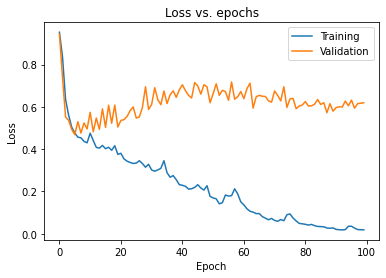

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## Regularization

If everything went well. You can see that we have overfitted on the training data.
We want to solve this with the help of regularization


We do this by usiong the same architecture as before but we add the following two things:

1) We add dropout layers with rate of 0.3 between each dense layer

2) We add l2 regularization with a weight decay of 1e-5 on each dense layer (except the last)


Search the tensorflow documentition on how to do this.

(Tip search for kernel regularization and for a layer called Dropout)


In [14]:
#Build the model
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
#Define the regularized model
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd) ,activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers
regularized_model = get_regularised_model(1e-5, 0.3)

In [16]:
# Compile the model as before

regularized_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [17]:
# Train the model, exaclty as before

history = regularized_model.fit(train_data, train_targets, epochs=100, validation_split=0.15,)


Train on 337 samples, validate on 60 samples
Epoch 1/100
337/337 [==============================] - 1s 1ms/sample - loss: 0.9632 - mae: 0.8316 - val_loss: 1.1434 - val_mae: 0.9134
Epoch 2/100
337/337 [==============================] - 0s 83us/sample - loss: 0.9349 - mae: 0.8196 - val_loss: 1.0397 - val_mae: 0.8694
Epoch 3/100
337/337 [==============================] - 0s 77us/sample - loss: 0.8333 - mae: 0.7485 - val_loss: 0.8022 - val_mae: 0.7550
Epoch 4/100
337/337 [==============================] - 0s 80us/sample - loss: 0.6930 - mae: 0.6919 - val_loss: 0.5963 - val_mae: 0.6510
Epoch 5/100
337/337 [==============================] - 0s 86us/sample - loss: 0.5962 - mae: 0.6337 - val_loss: 0.5487 - val_mae: 0.6263
Epoch 6/100
337/337 [==============================] - 0s 82us/sample - loss: 0.5850 - mae: 0.6227 - val_loss: 0.4963 - val_mae: 0.5710
Epoch 7/100
337/337 [==============================] - 0s 78us/sample - loss: 0.5494 - mae: 0.5983 - val_loss: 0.5220 - val_mae: 0.6170
Epoc

In [23]:
#Evaluate the model
regularized_model.evaluate(test_data, test_targets, verbose=2)

45/45 - 0s - loss: 0.9188 - mae: 0.7581


[0.9187525934643216, 0.7581359]

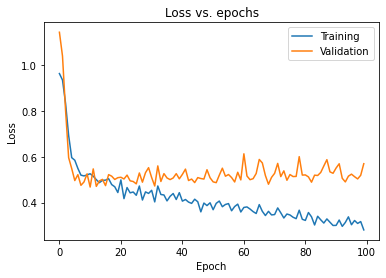

In [24]:
#Plot the training and validation data
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

## Regularization with early stopping

We could also regularized with early stopping. Train the (unregularized) model with early stopping. Compare the results of the early stopping model with the regularized model.

In [20]:
# Re-train the unregularised model with early stopping (use patience=2) and use the same settings as before
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_model = get_model()
early_stopping_model.compile(optimizer="adam", loss="mse")
early_stopping_history = early_stopping_model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False, callbacks=[EarlyStopping(patience=2)])


In [21]:
# Evaluate the model on the test set
print(early_stopping_model.evaluate(test_data, test_targets, verbose=2))


45/45 - 0s - loss: 0.7871
0.7870900299814012


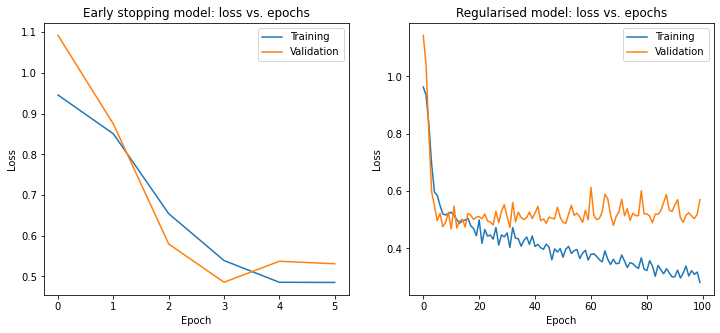

In [25]:
#Plot the regression curves for both
# Plot the training and validation loss for the early stopping model and the regularised model. 

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(early_stopping_history.history['loss'])
plt.plot(early_stopping_history.history['val_loss'])
plt.title('Early stopping model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()